<a href="https://colab.research.google.com/github/chekfung/cross_layer_final_project/blob/main/training_quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source Code

## Imports Needed Throughout the Project

In [1]:
# All Imports 
import sys
import numpy as np
import copy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
from google.colab import files

# argument parser
import easydict

## Get and Download Datasets

In [2]:
# MNIST Dataset (Images and Labels)
train_set = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

test_set = dsets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw



## More Helper Code for Training and Testing Accuracy

In [3]:
def fuse_conv_bn(model,out_model):

  conv_layer = None
  count = 0

  # 1. for loop to collect all Conv layers
  # 2. for loop to collect all BatchNorm layers
  for layer in model.modules():
    
    if isinstance(layer, nn.BatchNorm2d):

      conv_size = conv_layer.weight.size()


      with torch.no_grad():
        for i in range(conv_size[0]):

          
          # get the conv2d weights
          weights = conv_layer.weight[i]


          denominator = torch.sqrt(layer.eps+layer.running_var)
          gamma = layer.weight[i]
          beta = layer.bias[i]
          

          for j in range(conv_size[1]):
            for k in range(conv_size[2]):
              for l in range(conv_size[3]):
                # update out_model layer[count]

                if count == 0:
                  out_model.conv1.weight[i][j][k][l] = gamma * conv_layer.weight[i][j][k][l]  / denominator[i]  
                else:
                  out_model.conv2.weight[i][j][k][l] = gamma * conv_layer.weight[i][j][k][l]  / denominator[i]  

          # In i loop for bias since only 1D
          if count == 0:
            out_model.conv1.bias[i] = (gamma * (conv_layer.bias[i] - layer.running_mean[i])  / denominator[i]) + beta
          else:
            out_model.conv2.bias[i] = (gamma * (conv_layer.bias[i] - layer.running_mean[i])  / denominator[i]) + beta

        count += 1

    conv_layer = layer # conv2d


## FP32 Model 

In [4]:
class MyConvNet_FP32(nn.Module):
    def __init__(self, args):
        super(MyConvNet_FP32, self).__init__()
        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3
        self.lin2  = nn.Linear(7*7*32, 10)

    def forward(self, x):
        # Layer 1
        c1 = self.conv1(x)
        b1  = self.bn1(c1)
        a1  = self.act1(b1)
        p1  = self.pool1(a1)

        # Layer 2
        c2  = self.conv2(p1)
        b2  = self.bn2(c2)
        a2  = self.act2(b2)
        p2  = self.pool2(a2)

        # Flatten and Layer 3
        flt = p2.view(p2.size(0), -1)
        out = self.lin2(flt)
        return out
  
# model = MyConvNet(args)
# model = model.cuda()

## Quantization Helper Code

In [5]:
def simple_quantize_val(val, scale_factor, min_val, max_val):
  value = torch.round(val / scale_factor)

  if (value < min_val):
    value = min_val

  if (value > max_val):
    value = max_val

  return (value * scale_factor)

def fixed_point_quantize_val(val, num_bits, fractional_bits):
  integer_bits = num_bits - fractional_bits - 1 # Subtract one for sign bit
  smallest_step_size = 1 / np.power(2, fractional_bits)
  largest_number = (np.power(2, integer_bits) - 1) + ((np.power(2, fractional_bits)-1) * smallest_step_size)
  smallest_number = -1 * np.power(2, integer_bits)

  value = torch.round(val / smallest_step_size) * smallest_step_size

  if (value < smallest_number):
    value = smallest_number

  if (value > largest_number):
    value = largest_number

  return value

# Perhaps slightly optimized version?
def fixed_point_quantize_faster(val, smallest_step_size, largest_number, smallest_number):

  # Perform Pseudo Quantization
  value = torch.round(val / smallest_step_size) * smallest_step_size

  # Clamp Values
  if (value < smallest_number):
    value = smallest_number

  if (value > largest_number):
    value = largest_number

  return value

### NOTE: ONLY USE THIS SHIT ###
def optimized_tensor_fp_quantize(tens, step_size, largest_num, smallest_num):
  # Do everything in tensor operations
  new_tensor = torch.round(tens / step_size) * step_size
  torch.clamp(new_tensor, min=smallest_num, max=largest_num) 
  return new_tensor

# Right now, only for integer quantization.
def quantize_fp_model_weights(model):
  count = 0
  for layer in model.modules():
    if not isinstance(layer, (nn.ReLU, nn.MaxPool2d)) and count != 0:
        
      with torch.no_grad():
        layer.weight.data = optimized_tensor_fp_quantize(layer.weight.data, model.smallest_step_size, model.largest_num_representable, model.smallest_num_representable)

    count += 1
  
  return 0

def quantize_fp_model_biases(model):
  count = 0
  for layer in model.modules():
    if not isinstance(layer, (nn.ReLU, nn.MaxPool2d)) and count != 0:
        
      with torch.no_grad():
        layer.bias.data = optimized_tensor_fp_quantize(layer.bias.data, model.smallest_step_size, model.largest_num_representable, model.smallest_num_representable)

    count += 1
  
  return 0

In [6]:
def train_model(arg, model, criterion, optimizer, train_loader, quantize=False):
    print("---Training started")
    # Training the Model
    for epoch in range(arg.epochs):
        for i, (images, labels) in enumerate(train_loader):
            # Load Images into GPU
            images = images.cuda()
            labels = Variable(labels).cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            L1norm = model.parameters()
            arr = []

            # Calculate L1 Norm (if included in hyperparameters)
            if arg.L1norm == True:
                for name,param in model.named_parameters():
                    if 'weight' in name.split('.'):
                        arr.append(param)

                L1loss = 0
                for Losstmp in arr:
                    L1loss = L1loss+Losstmp.abs().mean()

                if len(arr) > 0:
                    loss = loss+L1loss/len(arr)

            if quantize:
                # quantize loss
                loss.data = optimized_tensor_fp_quantize(loss.data, model.smallest_step_size, model.largest_num_representable, model.smallest_num_representable)

            # Optimizer Step, Propagate Loss backwards
            loss.backward()

            if quantize:
              
                # quantize gradients
                for name,param in model.named_parameters():
                    # Print BEFORE Gradients
                    # print(gradient)

                    param.grad.data = optimized_tensor_fp_quantize(param.grad.data, model.smallest_step_size, model.largest_num_representable, model.smallest_num_representable)
                    
                    # Print AFTER Gradients
                    # print(gradient)
                
            optimizer.step()

            # # TODO: Need to quantize the biases as well.
            if quantize:
              quantize_fp_model_weights(model)
              quantize_fp_model_biases(model)

            if (i + 1) % 600 == 0:
                print('Epoch: [% d/% d], Step: [% d/% d], Loss: %.4f'
                        % (epoch + 1, arg.epochs, i + 1,
                        len(train_set) // arg.batch_size, loss.data.item()))


# Gets accuracy given dataset as well as total test loss
def get_acc(model, criterion, test_loader, quantized=False):
    correct = 0
    total = 0

    for images, labels in test_loader:
        images = images.cuda()
        labels = labels.cuda()
        outputs = model(images)
        testloss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        break

    if quantized:
      testloss = optimized_tensor_fp_quantize(testloss, model.smallest_step_size, model.largest_num_representable, model.smallest_num_representable)

    return ((100 * correct / total), testloss)

## Quantization Model

In [7]:
# Assume that we always 
class MyConvNet_FIXED_POINT(nn.Module):
    def __init__(self, args, num_bits, num_fractional_bits):
        super(MyConvNet_FIXED_POINT, self).__init__()

        # Fixed Point Parameters
        self.fp_bits = num_bits
        self.sign_bit = 1
        self.integer_bits = (num_bits - 1 - num_fractional_bits)
        self.fractional_bits = num_fractional_bits

        # Fixed Point Computed Values for Quantization
        self.smallest_step_size = 1 / np.power(2, num_fractional_bits)
        self.largest_num_representable = (np.power(2, self.integer_bits) - 1) + ((np.power(2, self.fractional_bits)-1) * self.smallest_step_size)
        self.smallest_num_representable = -1 * np.power(2, self.integer_bits)

        # Layer 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(16)
        self.act1  = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        # Layer 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(32)
        self.act2  = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        # Layer 3
        self.lin2  = nn.Linear(7*7*32, 10)

    # AUGMENT FORWARD PASS. forward pass not quantizes every single time we go through
    def forward(self, x):
        xq = optimized_tensor_fp_quantize(x, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        # Layer 1
        c1 = self.conv1(xq)
        c1q = optimized_tensor_fp_quantize(c1, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        b1  = self.bn1(c1q)
        b1q = optimized_tensor_fp_quantize(b1, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        a1  = self.act1(b1q)
        p1  = self.pool1(a1)

        # Layer 2
        c2  = self.conv2(p1)
        c2q = optimized_tensor_fp_quantize(c2, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        b2  = self.bn2(c2q)
        b2q = optimized_tensor_fp_quantize(b2, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        a2  = self.act2(b2q)
        p2  = self.pool2(a2)

        # Flatten and Layer 3
        flt = p2.view(p2.size(0), -1)
        out = self.lin2(flt)
        out_new = optimized_tensor_fp_quantize(out, self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)
        return out

    # def forward(self, x):
    #   # Layer 1
    #   c1 = self.conv1(x)
    #   b1  = self.bn1(c1)
    #   a1  = self.act1(b1)
    #   p1  = optimized_tensor_fp_quantize(self.pool1(a1), self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)

    #   # Layer 2
    #   c2  = self.conv2(p1)
    #   b2  = self.bn2(c2)
    #   a2  = self.act2(b2)
    #   p2  = optimized_tensor_fp_quantize(self.pool1(a2), self.smallest_step_size, self.largest_num_representable, self.smallest_num_representable)

    #   # Flatten and Layer 3
    #   flt = p2.view(p2.size(0), -1)
    #   out = self.lin2(flt)
    #   return out

In [8]:
class QuantizedConvNet(nn.Module):
    def __init__(self, model_fp32):
        super(QuantizedConvNet, self).__init__()
        # QuantStub converts tensors from floating point to quantized.
        # This will only be used for inputs.
        self.quant = torch.quantization.QuantStub()
        # DeQuantStub converts tensors from quantized to floating point.
        # This will only be used for outputs.
        self.dequant = torch.quantization.DeQuantStub()
        # FP32 model
        self.model_fp32 = model_fp32

    def forward(self, x):
        # manually specify where tensors will be converted from floating
        # point to quantized in the quantized model
        x = self.quant(x)
        x = self.model_fp32(x)
        # manually specify where tensors will be converted from quantized
        # to floating point in the quantized model
        x = self.dequant(x)
        return x

# Test Code Here


In [9]:
# Hyper Parameter for FashionMNIST
input_size = 784
num_classes = 10



## Example of instantiating a model, training it with given hyperparameters, etc

64
32
---Training started
Epoch: [ 1/ 1], Step: [ 600/ 3750], Loss: 0.2974
Epoch: [ 1/ 1], Step: [ 1200/ 3750], Loss: 0.6089
Epoch: [ 1/ 1], Step: [ 1800/ 3750], Loss: 0.1451
Epoch: [ 1/ 1], Step: [ 2400/ 3750], Loss: 0.3730
Epoch: [ 1/ 1], Step: [ 3000/ 3750], Loss: 0.2325
Epoch: [ 1/ 1], Step: [ 3600/ 3750], Loss: 0.3388
Test Accuracy: 93.75
Test Loss: 0.37356072664260864
32
16
---Training started
Epoch: [ 1/ 1], Step: [ 600/ 3750], Loss: 0.7889
Epoch: [ 1/ 1], Step: [ 1200/ 3750], Loss: 0.0621
Epoch: [ 1/ 1], Step: [ 1800/ 3750], Loss: 0.0597
Epoch: [ 1/ 1], Step: [ 2400/ 3750], Loss: 0.0675
Epoch: [ 1/ 1], Step: [ 3000/ 3750], Loss: 0.1866
Epoch: [ 1/ 1], Step: [ 3600/ 3750], Loss: 0.4002
Test Accuracy: 87.5
Test Loss: 0.25823974609375
16
8
---Training started
Epoch: [ 1/ 1], Step: [ 600/ 3750], Loss: 2.4219
Epoch: [ 1/ 1], Step: [ 1200/ 3750], Loss: 2.2266
Epoch: [ 1/ 1], Step: [ 1800/ 3750], Loss: 2.4219
Epoch: [ 1/ 1], Step: [ 2400/ 3750], Loss: 2.2539
Epoch: [ 1/ 1], Step: [ 30

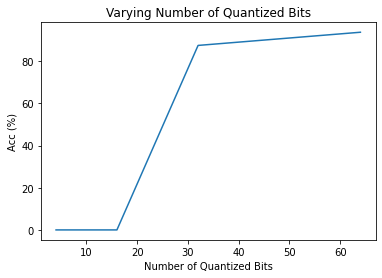

In [10]:
args = easydict.EasyDict({
        "batch_size": 16,
        "epochs": 1,
        "lr": 0.001,
        "enable_cuda" : True,
        "L1norm" : False,
        "simpleNet" : True,
        "activation" : "relu", #relu, tanh, sigmoid
        "train_curve" : True, 
        "optimization" :"Adam"
})

# Dataset Loader (Input Pipeline)
quantize = True
train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = args.batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = args.batch_size, shuffle = False)

num_bits_test = [64, 32, 16, 8, 4]
num_fractional_bits = [32, 16, 8, 4, 2]
acc = []

for (num_bits,num_fractional_bits) in zip(num_bits_test, num_fractional_bits):
  print(num_bits)
  print(num_fractional_bits)
  # Declare Model
  model = MyConvNet_FIXED_POINT(args, num_bits, num_fractional_bits).cuda()
  #model = MyConvNet_FP32(args).cuda()

  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.Adam(model.parameters(), lr = args.lr) 

  # Training
  train_model(args, model, criterion, optimizer, train_loader, quantize)

  # Need to quantize the model afterwards
  quantize_fp_model_weights(model)

  # Testing ARC
  test_acc, test_loss = get_acc(model, criterion, test_loader, quantize)
  print("Test Accuracy: {}".format(test_acc))
  print("Test Loss: {}".format(test_loss))

  acc.append(test_acc.item())

plt.figure(0)
plt.plot(num_bits_test, acc)
plt.title("Varying Number of Quantized Bits")
plt.xlabel("Number of Quantized Bits")
plt.ylabel("Acc (%)")
plt.show()


## Preston's Training of Model

In [11]:
# cuda_device = torch.device("cuda:0")
# cpu_device = torch.device("cpu:0")

# # Initial model
# FP_model = MyConvNet_FP32(args).cuda()
# FP_fused_model = MyConvNet_FP32(args)

# # Training stuff
# criterion = nn.CrossEntropyLoss().cuda()
# optimizer = torch.optim.SGD(FP_model.parameters(), lr = learning_rate) 

# train_model(FP_model, criterion, optimizer, train_loader)



In [12]:
# test_acc_FP, test_loss_FP = get_acc(FP_model, criterion, test_loader)
# print("Test Accuracy: {}".format(test_acc_FP))
# print("Test Loss: {}".format(test_loss_FP))


In [13]:

# copy_models(FP_model,FP_fused_model)   
# fuse_conv_bn(FP_model,FP_fused_model)

# quantized_model = QuantizedConvNet(model_fp32=FP_fused_model).to(cpu_device)

# quantization_config = torch.quantization.get_default_qconfig("fbgemm")
# quantized_model.qconfig = quantization_config
# torch.quantization.prepare_qat(quantized_model, inplace=True)

# quantized_model.to(cuda_device)
# train_model(quantized_model, criterion, optimizer, train_loader)
# # quantized_model.to(cpu_device)

# # quantized_model = torch.quantization.convert(quantized_model, inplace=True)



In [14]:


# test_acc, test_loss = get_acc(quantized_model, criterion, test_loader)
# print("Test Accuracy: {}".format(test_acc))
# print("Test Loss: {}".format(test_loss))

